Idea:  
- Ignore edge extraction.   
- Attempt to bring in white markings etc into training 
- Identify contour, use contour to crop the tail out of water background
- Cut 1/4 bottom to remove water splash
- Feed 3/4 tail img into training model

In [1]:
import skimage
from skimage import measure
import matplotlib.pyplot as plt
from skimage import data, io, color
from skimage.filters import threshold_li
from skimage.filters import try_all_threshold
from skimage.color import rgb2hsv
import numpy as np
from matplotlib import path
from matplotlib.path import Path
import matplotlib.patches as patches
import math

In [6]:
# Function to apply a Value filter to input image
# Input: Path to image
# Output: image converted to 2-dimensional array, with one channel (S or V) reduced to 0; other 2 channels unchanged
# Improvement from exp 15: returning channel is decided by param "channel" instead of always V
def hsv_value_filter(imgpath, channel='v'):
    rgb_img = skimage.io.imread(imgpath)
    hsv_img = rgb2hsv(rgb_img)
    value_img = hsv_img[:, :, 2] # Exp 13.3
    saturation_img = hsv_img[:, :, 1] # Exp 15
    if (channel == 's'):
        return saturation_img
    elif (channel == 'v'):
        return value_img    
    return None


# Function to find contour line from grayscale image
# Input: Grayscale or single-channel hsv/rgb image (2-dimensional array with values from 0-1)
# output: Contour line
def find_contour(tail_img_gray):
    #tail_img_gray = color.rgb2gray(tail_img)  
    mask_threshold = threshold_li(tail_img_gray)
    tail_img_mask = tail_img_gray < mask_threshold
    
    # Improvement 13.1: Add left - right borders 5 pixels each
    tail_img_mask[:,0:5] = 0
    tail_img_mask[:,-6:-1] = 0
    
    contours = measure.find_contours(tail_img_mask, 0.9) 
    # Find the largest contour in the list of contours
    contours.sort(key=len,reverse=True)
    largest_contour = contours[0]
    
    # Improvement 13.2: Compare the largest (1) vs 2nd-largest (2) contour
    # If no_of_points(2) and area(2) are >= 0.5 those of (1), 
    # then there's a high chance that it's a picture with notch point under water
    # In that case draw a line to join 2 flukes & find contour again
    if(len(contours) > 1):
        c1 = contours[0] # largest
        c2 = contours[1] # 2nd largest

        no_of_points_ratio = len(c2)/len(c1)
        area_ratio = PolyArea(c2[:, 1],c2[:, 0])/PolyArea(c1[:, 1],c1[:, 0])
        
        # we expect the two flukes to cover ~ the same area, otherwise it's most likely just a random area of water
        if (no_of_points_ratio >= 0.5 and area_ratio >=0.5): 
            p1, p2 = closest_pair(c1,c2)
            # Visualize the 2 closest points on img mask
            #print('Visualizing the two closest points')
            #fig = plt.figure(figsize=(24,9))
            #plt.imshow(tail_img_mask, cmap='gray')
            #plt.plot(p1[1],p1[0], marker='o', markersize=10, color="blue")
            #plt.plot(p2[1],p2[0], marker='o', markersize=10, color="red")

            # draw a L-connector of 6 pixels between 2 contours
            draw_L_shape(tail_img_mask,p1,p2,6)

            # Find contours again on the jont contour
            contours = measure.find_contours(tail_img_mask, 0.9) 
            # Find the largest contour in the list of contours
            contours.sort(key=len,reverse=True)
            #largest_contour = contours[0]

            largest_contour = contours[0]
            #c2 = contours[1]
            #c3 = contours[2]
    
    return largest_contour

# https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
# Function to rotate a set of points around an origin by a predefined degrees
# Input: set of points, for example a contour line; origin of rotation; rotation angle in degree
# Output: the same set of points rotated
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

# Function to extract edge line from a given contour. 
# Edge line is tilted so that the straight line connecting left-right tips is parallel with x axis
# Input: contour line
# Ourput: edge line, tilted horizontally
def extract_edge_tilt(contour):
    # Move contour to line towards root (0,0)
    contour[:,0] -= contour[:,0].min()
    contour[:,1] -= contour[:,1].min()

    # Get middle y point of contour line
    middle_y = (contour[:,0].max() - contour[:,0].min())/2

    # FIND NOTCH POINT
    # Get 25% and 75% on x as left and right boundaries to find notch point
    left_bound = contour[:,1].max() * 0.25
    right_bound = contour[:,1].max() * 0.75

    # Cut the area containing notch point by middle_y, left and right boundaries
    c_notch = contour[ (contour[:,0] < middle_y) & (contour[:,1] > left_bound) & (contour[:,1] < right_bound)]

    # If there is no point in the notch area => bad contour line, stops finding edge & returns bottom half of the contour image
    if (len(c_notch) == 0):
        return contour[(contour[:,0] < middle_y)]

    # Find notch points == points that have the highest y in the notch area
    c_notch_y = c_notch[:,0].max()
    c_notch_points = c_notch[c_notch[:,0] == c_notch_y]

    notch_point = c_notch_points[0]

    # FIND LEFT-RIGHT TIPS OF THE FLUKE
    # Cut the bottom half of the tail
    c_bottom = contour[ (contour[:,0] < middle_y)]
    # Find the left tip
    left_tip_x = c_bottom[:,1].min()
    left_tips = c_bottom[c_bottom[:,1] == left_tip_x]
    left_tip = left_tips[0] # if there are several points at min_x
    # Find the right tip
    right_tip_x = c_bottom[:,1].max()
    right_tips = c_bottom[c_bottom[:,1] == right_tip_x]
    right_tip = right_tips[-1] # if there are several points at max_x
    
    # CREATE A PATH OBJECT THAT BOUNDS THE FLUKE
    # The path is limited by 5 points: bottom_left,left_tip, notch_point, right_tip,bottom_right
    bottom_left = np.array([0,left_tip[1]])
    bottom_right = np.array([0,right_tip[1]])
    verts = [bottom_left,left_tip, notch_point, right_tip,bottom_right,bottom_left]
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    edge_path = Path(verts, codes)
    
    # Extract the edge from bottom half of the image using the path as a mask
    c_edge = c_bottom[edge_path.contains_points(c_bottom)]
    
    # Identify the tilt angle
    diff = right_tip - left_tip
    tilt_angle = np.rad2deg(math.atan(diff[0]/diff[1]))
    
    # Identify rotate center - midpoint of left and right tips
    rotate_center = ((left_tip[0]+right_tip[0])/2,(left_tip[1]+right_tip[1])/2)
        
    # Rotate the edge to balance horizontally around the rotate center
    c_edge_tilted = rotate(c_edge, origin=rotate_center, degrees=tilt_angle)
    return c_edge_tilted

# function to identify the corner point of the L shape connecting two given points 
# L shape is drawn given that the horizontal edge must be below the vertical edge. i.e ┕ and ┙ =>ok, ┍ and ┑ => not ok
def find_corner_point (point1, point2):
    (x1, y1) = point1
    (x2, y2) = point2
    y = min(y1,y2)
    if(y == y1):
        x = x2
    else: 
        x = x1
    return (x,y)

# Function to draw a L shape in a given black-white image (2d array)
# between 2 given points
def draw_L_shape(img, point1, point2, width):
    (x1, y1) = point1
    (x2, y2) = point2
    (xc, yc) = find_corner_point(point1, point2)
    half_width = int(width/2)
    # Draw the horizontal line:
    if(x1<x2):
        img[x1-half_width:x2+half_width,yc-half_width:yc+half_width] = 1
    else:
        img[x2-half_width:x1+half_width,yc-half_width:yc+half_width] = 1
    # Draw vertical line
    if(y1<y2):
        img[xc-half_width:xc+half_width,y1-half_width:y2+half_width] = 1
    else:
        img[xc-half_width:xc+half_width,y2-half_width:y1+half_width] = 1

# function to find one point in a curve that is closest to a given point
def closest_node(node, nodes):
    dist = np.sum((nodes - node)**2, axis=1)
    closest_index = np.argmin(dist)
    return nodes[closest_index], dist[closest_index]

# function to find one point in a curve that is closest to a given point
# return values is converted to int because later are used as matrix indexes
def closest_pair(c1,c2):
    min_point_c2 = c2[0]
    min_point_c1, min_dist = closest_node(c2[0], c1)
    for point in c2:
        p, d = closest_node(point, c1)
        if d < min_dist:
            min_point_c2 = point
            min_point_c1 = p
            min_dist = d
    return min_point_c1.astype(int), min_point_c2.astype(int)

# function to calculate area limited by a polygon
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

# Test with 1 image

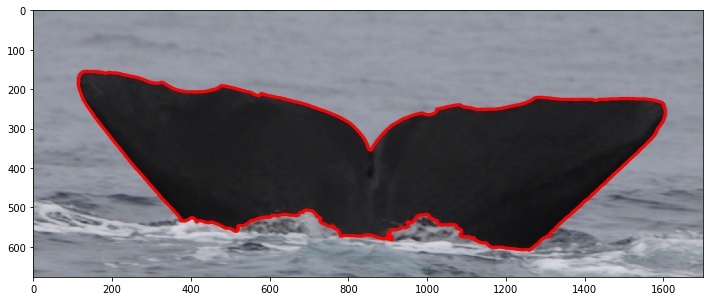

In [27]:
img_path = '../data/test_val/PM-WWA-20170321-046.jpg'
img_rgb = skimage.io.imread(img_path)
img_1d = hsv_value_filter(img_path,'v')
contour = find_contour(img_1d)
plt.figure(figsize=(12,6))   
plt.imshow(img_rgb, interpolation='nearest'); 
plt.plot(contour[:, 1], contour[:, 0],  linewidth=3, color = 'red')

In [34]:
#https://stackoverflow.com/questions/39642680/create-mask-from-skimage-contour
import scipy.ndimage as ndimage    
# Create an empty image to store the masked array
mask = np.zeros_like(img_1d, dtype='bool')
# Create a contour image by using the contour coordinates rounded to their nearest integer value
mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
# Fill in the hole created by the contour boundary
mask = ndimage.binary_fill_holes(mask)
# Invert the mask since you want pixels outside of the region
#mask = ~mask

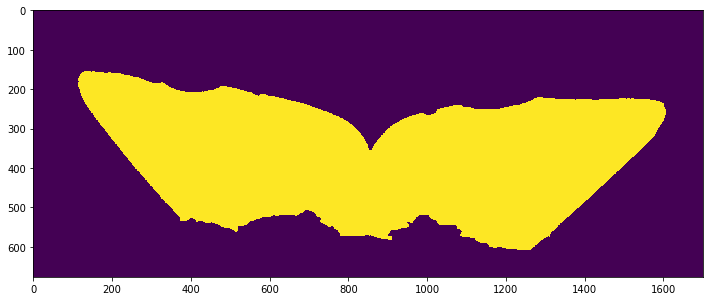

In [35]:
plt.figure(figsize=(12,6))
plt.imshow(mask)

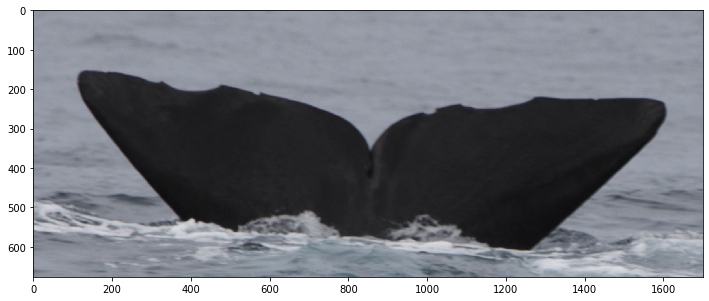

In [43]:
img_crop= img_rgb[mask]
plt.figure(figsize=(12,6))
plt.imshow(img_rgb[:,:,], interpolation='nearest')

In [48]:
mask.shape

(677, 1700)

In [39]:
img_rgb.shape

(677, 1700, 3)

In [50]:
img_rgb[:, :, 0][mask] = 0
img_rgb[:, :, 1][mask] = 0
img_rgb[:, :, 2][mask] = 0

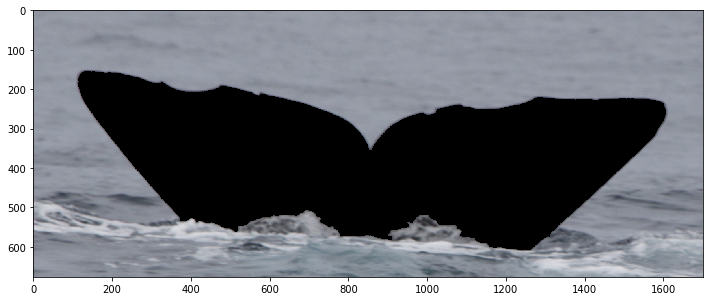

In [52]:
plt.figure(figsize=(12,6))
plt.imshow(img_rgb[:,:,], interpolation='nearest')

In [67]:
img_rgb = np.ma.array(img_rgb, mask=mask)

MaskError: Mask and data not compatible: data size is 3452700, mask size is 1150900.

In [59]:
import numpy as np

nx = 2
nt = 4

field3d = np.random.rand(nt, nx, nx)
field2d = np.random.rand(nx, nx)

field3d_mask = np.zeros(field3d.shape, dtype=bool)

for t in range(nt):
    field3d_mask[t,:,:] = field2d > 0.3

field3d = np.ma.array(field3d, mask=field3d_mask)

print(field2d)
print(field3d)

[[0.59334445 0.28351709]
 [0.641575   0.00149236]]
[[[-- 0.9564005717333376]
  [-- 0.5148065725625265]]

 [[-- 0.8630935720496438]
  [-- 0.5316908488104733]]

 [[-- 0.626774547457383]
  [-- 0.1016097726609223]]

 [[-- 0.608340296754277]
  [-- 0.9414296130568193]]]


In [60]:
field3d.shape

(4, 2, 2)

In [61]:
field2d.shape

(2, 2)

In [62]:
field3d_mask = np.broadcast_to(field2d > 0.3, field3d.shape)

In [64]:
field3d_mask.shape

(4, 2, 2)

In [65]:
field3d = np.ma.array(field3d, mask=field3d_mask)

In [66]:
field3d

masked_array(
  data=[[[--, 0.9564005717333376],
         [--, 0.5148065725625265]],

        [[--, 0.8630935720496438],
         [--, 0.5316908488104733]],

        [[--, 0.626774547457383],
         [--, 0.1016097726609223]],

        [[--, 0.608340296754277],
         [--, 0.9414296130568193]]],
  mask=[[[ True, False],
         [ True, False]],

        [[ True, False],
         [ True, False]],

        [[ True, False],
         [ True, False]],

        [[ True, False],
         [ True, False]]],
  fill_value=1e+20)